<a href="https://colab.research.google.com/github/DayenaJeong/FS_neuron/blob/main/FSneuron_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [20]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [21]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()
        self.num_params = num_params
        self.init_params()

    def init_params(self):
        # Swish
        if self.num_params == 4:
            h = torch.tensor([6.0247, 3.0090, 1.5470, 1.0945])
            d = torch.tensor([6.1718, 3.0962, 1.5492, 0.7664])
            T = torch.tensor([5.8070, 2.8584, 1.3577, 0.5687])
        elif self.num_params == 8:
            h = torch.tensor([3.6760, 2.8168, 2.3811, 1.3095, 0.8152, 0.3878, 0.1751, 2.4152])
            d = torch.tensor([3.6922, 2.9805, 2.4332, 1.3228, 0.8048, 0.3861, 0.1863, 0.1023])
            T = torch.tensor([8.2595, 3.5255, 2.5539, 1.7761, 0.9528, 0.5461, 0.3573, 0.2881])
        elif self.num_params == 12:
            h = torch.tensor([1.1299, 6.8735, 4.4682, 2.0329, 1.3388, 0.7357, 0.7149, 0.4261, 0.6461, 0.4154, 0.2179, 0.3444])
            d = torch.tensor([-0.2083,  7.0264,  4.6516,  2.1096,  1.3740,  0.7480,  0.6828,  0.3809, 0.4077,  0.2240,  0.1159,  0.0536])
            T = torch.tensor([-3.5203,  5.9076,  4.0212,  1.8142,  0.9658,  0.3212, -0.0740, -0.4722, -0.7314, -1.2238, -1.3265, -1.4648])
        elif self.num_params == 16:
            h = torch.tensor([0.5602, 0.3329, 1.2282, 1.4916, 1.0170, 1.0777, 0.9202, 1.2722, 2.8685, 1.3212, 0.8411, 0.3989, 0.1870, 0.0936, 0.0616, 1.1349])
            d = torch.tensor([0.3161,  0.2175, -0.2093,  1.6195,  1.0840,  1.1121,  0.9249,  1.2900, 2.8708,  1.3277,  0.8375,  0.3912,  0.1875,  0.0973,  0.0640,  0.0406])
            T = torch.tensor([0.0984, -0.0835, -3.5130,  0.6933,  0.1460,  0.0137,  0.9415,  0.2020, 1.2894, -0.2560, -0.7142, -1.1954, -1.3832, -1.4649, -1.4901, -1.5134])

        self.h = nn.Parameter(h + torch.poisson(torch.full(h.size(), 0.001)))
        self.d = nn.Parameter(d + torch.poisson(torch.full(d.size(), 0.001)))
        self.T = nn.Parameter(T + torch.poisson(torch.full(T.size(), 0.001)))

    def add_noise(self):
        # Adding Poisson noise every 100 epochs
        self.h.data += torch.poisson(torch.full(self.h.size(), 0.001))
        self.d.data += torch.poisson(torch.full(self.d.size(), 0.001))
        self.T.data += torch.poisson(torch.full(self.T.size(), 0.001))

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

K=4

Epoch 1/20000, Loss: 0.03879478946328163
Epoch 1001/20000, Loss: 0.5893630385398865
Epoch 2001/20000, Loss: 0.46276742219924927
Epoch 3001/20000, Loss: 0.5562471747398376
Epoch 4001/20000, Loss: 0.6852218508720398
Epoch 5001/20000, Loss: 1.1409896612167358
Epoch 6001/20000, Loss: 1.3120594024658203
Epoch 7001/20000, Loss: 1.816597819328308
Epoch 8001/20000, Loss: 3.3972256183624268
Epoch 9001/20000, Loss: 4.376341342926025
Epoch 10001/20000, Loss: 3.909403085708618
Epoch 11001/20000, Loss: 4.0741424560546875
Epoch 12001/20000, Loss: 4.315042972564697
Epoch 13001/20000, Loss: 4.454644203186035
Epoch 14001/20000, Loss: 3.0950214862823486
Epoch 15001/20000, Loss: 4.445108413696289
Epoch 16001/20000, Loss: 3.3345258235931396
Epoch 17001/20000, Loss: 3.540452718734741
Epoch 18001/20000, Loss: 8.008036613464355
Epoch 19001/20000, Loss: 7.12286376953125
Loss values: [0.03879478946328163, 0.16175101697444916, 0.18153582513332367, 0.1861153393983841, 0.24645531177520752, 0.5893630385398865, 0.4

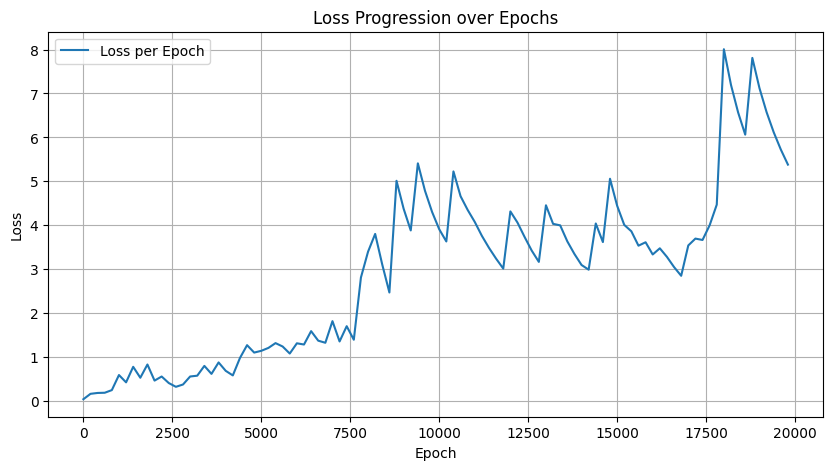

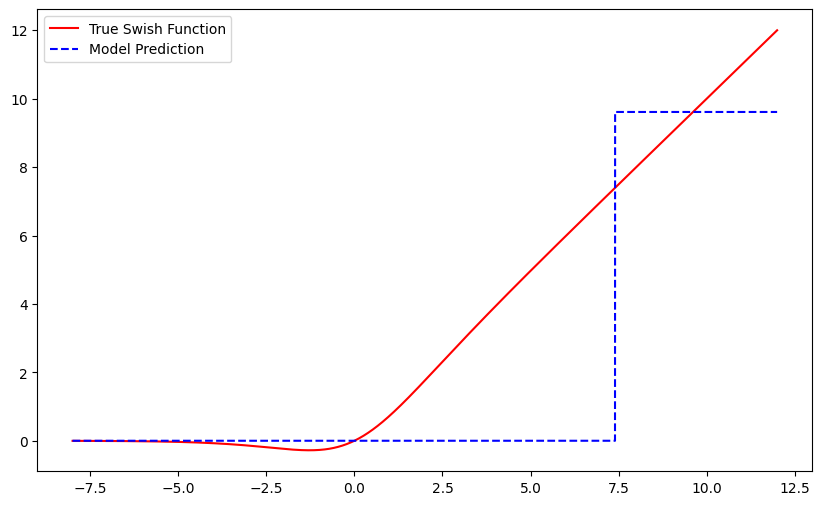

In [22]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()

    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

K=8

Epoch 1/20000, Loss: 0.008968070149421692
Epoch 1001/20000, Loss: 0.41974034905433655
Epoch 2001/20000, Loss: 0.27868136763572693
Epoch 3001/20000, Loss: 0.3520093858242035
Epoch 4001/20000, Loss: 0.7859556078910828
Epoch 5001/20000, Loss: 0.45226335525512695
Epoch 6001/20000, Loss: 0.5483604669570923
Epoch 7001/20000, Loss: 0.46266961097717285
Epoch 8001/20000, Loss: 1.4893718957901
Epoch 9001/20000, Loss: 1.0479274988174438
Epoch 10001/20000, Loss: 2.1690096855163574
Epoch 11001/20000, Loss: 2.3575451374053955
Epoch 12001/20000, Loss: 2.7573511600494385
Epoch 13001/20000, Loss: 3.3267107009887695
Epoch 14001/20000, Loss: 4.576578617095947
Epoch 15001/20000, Loss: 5.82564115524292
Epoch 16001/20000, Loss: 4.876262664794922
Epoch 17001/20000, Loss: 3.880361318588257
Epoch 18001/20000, Loss: 3.2564539909362793
Epoch 19001/20000, Loss: 3.5350334644317627
Loss values: [0.008968070149421692, 0.38611510396003723, 0.43737679719924927, 0.5344007015228271, 0.5323622822761536, 0.419740349054336

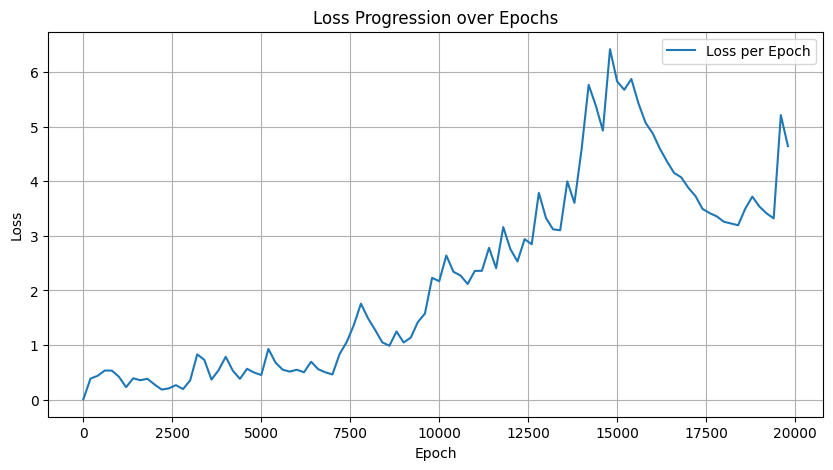

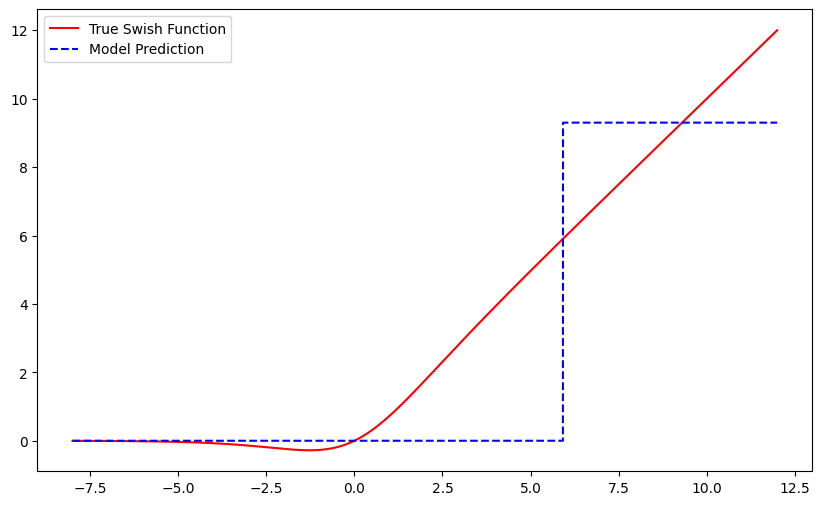

In [23]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()

    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

K=12

In [24]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()

    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.0020457119680941105
Epoch 1001/20000, Loss: 0.5239527821540833
Epoch 2001/20000, Loss: 0.4385567307472229
Epoch 3001/20000, Loss: 1.2232320308685303
Epoch 4001/20000, Loss: 0.7921130657196045
Epoch 5001/20000, Loss: 0.9838653206825256
Epoch 6001/20000, Loss: 2.1255650520324707
Epoch 7001/20000, Loss: 1.9452035427093506
Epoch 8001/20000, Loss: 1.3935143947601318
Epoch 9001/20000, Loss: 1.820810317993164
Epoch 10001/20000, Loss: 1.7990866899490356
Epoch 11001/20000, Loss: 1.3367518186569214
Epoch 12001/20000, Loss: 1.176903486251831
Epoch 13001/20000, Loss: 2.7015318870544434
Epoch 14001/20000, Loss: 3.716968059539795
Epoch 15001/20000, Loss: 5.272458553314209


K=16

Epoch 1/20000, Loss: 0.001041881274431944
Epoch 1001/20000, Loss: 0.9385979175567627
Epoch 2001/20000, Loss: 0.980182409286499
Epoch 3001/20000, Loss: 1.1366783380508423
Epoch 4001/20000, Loss: 0.7094545364379883
Epoch 5001/20000, Loss: 0.5961675047874451
Epoch 6001/20000, Loss: 1.0500038862228394
Epoch 7001/20000, Loss: 0.8859595060348511
Epoch 8001/20000, Loss: 0.8839670419692993
Epoch 9001/20000, Loss: 0.9203018546104431
Epoch 10001/20000, Loss: 0.8059074878692627
Epoch 11001/20000, Loss: 0.7090020179748535
Epoch 12001/20000, Loss: 0.8813344240188599
Epoch 13001/20000, Loss: 1.723696231842041
Epoch 14001/20000, Loss: 1.612207055091858
Epoch 15001/20000, Loss: 1.8195611238479614
Epoch 16001/20000, Loss: 2.355546474456787
Epoch 17001/20000, Loss: 1.9346181154251099
Epoch 18001/20000, Loss: 3.5502967834472656
Epoch 19001/20000, Loss: 2.775783061981201
Loss values: [0.001041881274431944, 0.08588183671236038, 0.39060303568840027, 0.6581788063049316, 0.3887152373790741, 0.9385979175567627

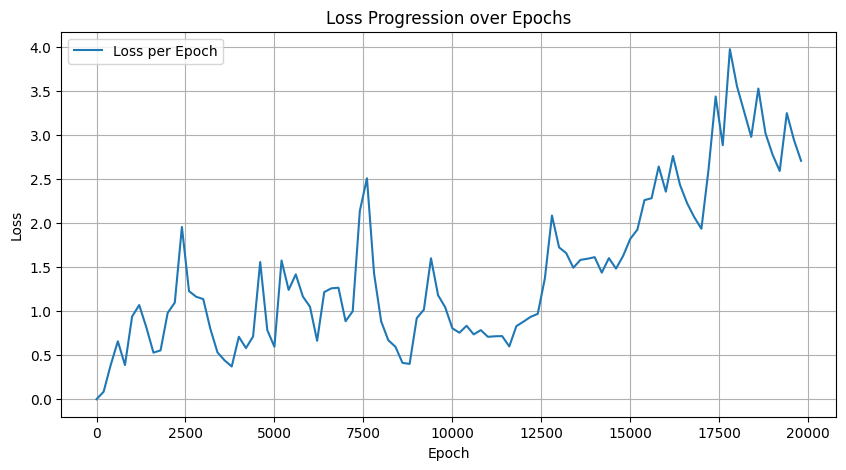

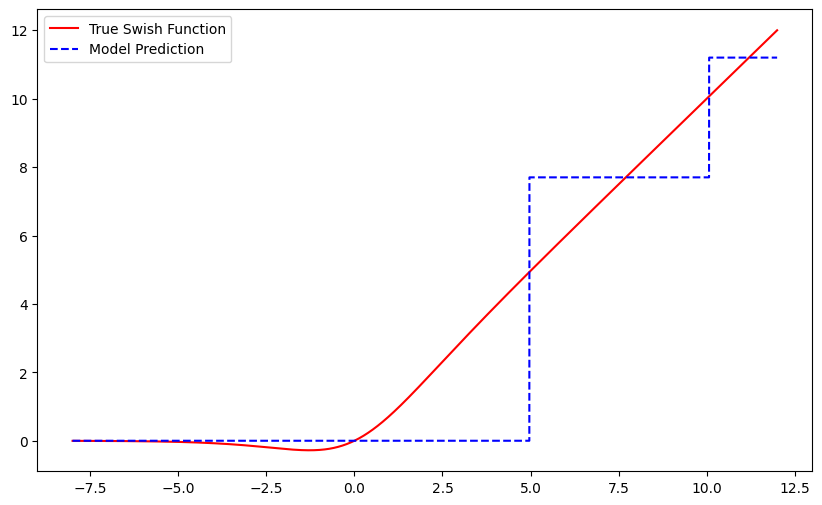

In [ ]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()

    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()